# Assessing models of innovation in literary studies

The ultimate goal of this project is to understand cultural change by asking where, and how, the future emerges. Are some academic journals and some publishers of fiction, for instance, consistently on the leading edge of change? How durable are those patterns?

This is a relatively straightforward descriptive question, not a question about causal mechanisms. But we don't currently have ground truth about it. We can certainly observe that some journals are more widely cited, and some works of fiction more widely discussed. But that's evidence about reputation, and we have reason to suspect that reputations perpetuate themselves. It's a different matter to measure actual innovation.

How could we measure it? Several different methods have been proposed, and they haven't yet been rigorously compared. Most of the methods we're examining will involve some version of the approach in Barron et al 2018, which directly compares a text to both its precursors and successors. The open questions about this method are a) how to *construct* a space in which to measure "similarity," and b) how to do the measuring -- e.g., do you consider every part of a document or judge a document at "its most innovative"?

But we're also considering the method in Vicinanza et al 2022, which evaluates texts in a basically different way.

As mentioned above, we don't have ground truth about innovation. That's exactly why our inquiry is necessary. But we can measure several social variables that would, intuitively, be expected to correlate with innovation and that have been observed to correlate with all existing modes of measuring it.

1. **Youth.** For obvious reasons, young people are likely to be less like the past and more like the future. This isn't an ironclad law: it's not impossible for change to come from older writers. But since generational succession is part of the way change happens, we would expect works by younger authors to have — on *average* — a higher chance of introducing new patterns. And in fact a strong correlation between youth and innovation has been observed in previous work.

2. **Wide circulation and acknowledged influence.** As we've noted, a reputation for being "influential" is not the same thing as actual influence. One can imagine a world where these two variables could have no relation at all. But in practice previous research has observed a moderately strong relationship between measures of circulation (reviews, citations, and sales, for instance) and measures of textual innovation. We don't yet know how this connection works. Do books become prominent because novelty helps them grab attention? Or does wide circulation produce innovation, since widely-circulated texts have a better chance to shape the future? We hope to cast more light on the question. But the relationship has, in any case, been observed too widely to be a local accident.

These social variables don't give us firm ground truth. But they do give us leverage, because they're relatively independent from each other. Young writers are not, as a rule, more widely cited and reviewed than old ones. So if we find a measure of textual innovation that correlates strongly both with youth *and* with acknowledged influence, we have some reason to infer that measure is identifying texts "where the future emerged." The inference is not deductively certain, but that's the combination of signals we would expect our construct to produce, and we don't at present have other explanations for it.

Our primary goal in this notebook will be to compare different measures of innovation with the second kind of ground truth: measures of citation. In the fiction notebook we'll also look at (1) author age. 

Finally, a substantive question about academic writing will emerge in this notebook. Does innovation -- however we measure it -- correlate more strongly with citation in recent years?

In [1]:
# necessary imports

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

### Load metadata

The metadata we load includes paperId, date of publication, and the number of citations found in Semantic Scholar.

We exclude rows without a paperId (these were not found in S2). We also create a secondary metadata table, `rschmeta`, that is limited to research articles. Most articles in the dataset are research articles, but we do also have review articles. Precocity was calculated using both categories, but we can limit to the former category if we like; they tend to be longer and tend to have more citations, so we'd expect them to produce a stronger signal.

In [2]:
meta = pd.read_csv('../metadata/litstudies/LitMetadataWithS2.tsv', sep = '\t')
meta = meta.loc[~pd.isnull(meta.paperId), : ]
meta.rename(columns={'paperId': 'docid'}, inplace=True)
meta.set_index('docid', inplace = True)
rschmeta = meta.loc[meta.doctype == 'article | research-article', : ]

### Measuring the strength of the relationship between precocity and citation

We've been informally evaluating representational spaces (topic models and embeddings) by a) calculating precocity in that space and then b) measuring Pearson's correlation with log(citations) in different segments of time. This gives us a curve that we can examine visually.

Segmentation by time is a quick and easy way of handling the fact that the average number of citations varies greatly over the period we're studying. (Mean precocity also varies a little.)

But to rigorously compare different representational spaces we probably also want to train a model that describes the whole dataset at once. To do this we'll include time as an independent variable, and represent it in a non-linear way. (We don't know that the effects of time are smoothly linear.)

In [3]:
# A function that models the predictive effect of precocity on log(citations),
# while controlling for the effect of time.

def controlled_model(reg_df):

	# Define the independent variables including the interaction term
	columns = ['novelty', 'precocity', 'precocity^2']
	for yr in range(1920, 2000, 5):
		columns.append('year' + str(yr))
	
	X = []
	for idx, row in reg_df.iterrows():
		newrow = dict()
		newrow['precocity'] = row['precocity']
		newrow['novelty'] = row['novelty']
		newrow['precocity^2'] = row['precocity'] ** 2
		newrow['logcitations'] = row['logcitations']
		for yr in range(1920, 2000, 5):
			col = 'year' + str(yr)
			if (row['date'] >= yr) and (row['date'] <= yr + 5):
				newrow[col] = 1
			else:
				newrow[col] = 0
		X.append(newrow)

	X = pd.DataFrame(X)

	# Add a constant to the model (the intercept)
	X = sm.add_constant(X)

	# Define the dependent variable
	y = X['logcitations']

	X = X.drop('logcitations', axis=1)

	# Fit the linear regression model
	model = sm.OLS(y, X).fit()

	# Print the summary of the model
	print(model.summary())

In [4]:
# We also need a function to visualize results over time 

def visualize_results(rlist, ryears):
    df = pd.DataFrame({'year': ryears, 'correlation': rlist})

    minvalue = 0 if min(df['correlation']) >= 0 else min(df['correlation']) - 0.02

    plt.figure(figsize=(10, 6))
    sns.lineplot(df, x='year', y='correlation', marker='o')

    plt.xlabel('Year')
    plt.ylabel('Correlation of precocity with log(citations)')
    plt.title('Strength of correlation')

    plt.ylim(minvalue, max(df['correlation']) + 0.02)

    if minvalue < 0:
        plt.axhline(0, linestyle='--', color='red')

    plt.show()

### The topic model

We'll start with our current topic model of literary studies. This has been updated from the fall; the current version is trained on a flat distribution across time. For articles that don't "fit" into the flat distribution, we infer topic distributions using an inferencer. This very slightly outperforms our earlier model, but the difference is not huge.

There are many different ways to measure similarity in this space. Let's start by visualizing and modeling the one that performs best. Then we'll compare others.

1920 - 20/0.25/1.0, n = 1755, 0.05249
1930 - 20/0.25/1.0, n = 2641, 0.09514
1940 - 20/0.25/1.0, n = 2388, 0.16454
1950 - 20/0.25/1.0, n = 3104, 0.19934
1960 - 20/0.25/1.0, n = 3951, 0.19345
1970 - 20/0.25/1.0, n = 5160, 0.17819
1980 - 20/0.25/1.0, n = 5238, 0.25274
1990 - 20/0.25/1.0, n = 4076, 0.34832


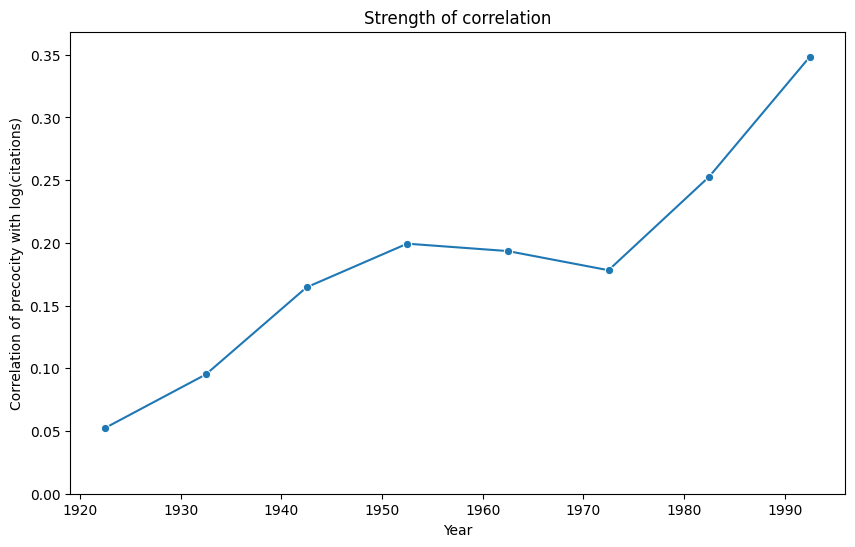

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     146.6
Date:                Fri, 05 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:13:29   Log-Likelihood:                -43848.
No. Observations:               28313   AIC:                         8.774e+04
Df Residuals:                   28293   BIC:                         8.790e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1459      0.082     13.947      

In [5]:
def run_model(path_to_model, metadata, chunksused = 0.25, fractioncompared = 1.0):
    precocity = []
    novelty = []
    date = []
    logcitations = []
    docids = []
    rlist = []
    ryears = []

    for decade in range(1920, 2000, 10):
        
        data = pd.read_csv(path_to_model + str(decade) + 's_docs.tsv', sep = '\t')

        data.set_index('docid', inplace=True)

        data = data.join(metadata['new_cite_count'], how='inner')
        data['logcitations'] = np.log(data.new_cite_count + 1)

        selected = data.loc[(data.time_radius == 20) & (data.filtered == 'trainauthquote') &
            (data.chunks_used == chunksused) & (data.fraction_compared == fractioncompared), :]
        
        r, p = pearsonr(selected.logcitations, selected.precocity)
        print(f"{decade} - 20/{chunksused}/{fractioncompared}, n = {selected.shape[0]}, {round(r, 5)}")

        precocity.extend(selected.precocity.values.tolist())
        novelty.extend(selected.novelty.values.tolist())
        date.extend(selected.date.values.tolist())
        logcitations.extend(selected.logcitations.values.tolist())
        docids.extend(selected.index.tolist())

        rlist.append(r)
        ryears.append(decade + 2.5)

    visualize_results(rlist, ryears)
    reg_df = pd.DataFrame({'precocity': precocity, 'novelty': novelty, 'date': date, 
                           'logcitations': logcitations, 'docid': docids})
    controlled_model(reg_df)
    return reg_df

reg_df = run_model('../topicmodel/flatresults/precocity_flat_', meta, chunksused = 0.25, fractioncompared = 1.0)

**Interpretation**

The key number to attend to above is r-squared, which suggests that 9% of the variance in log(citations) is explained by our model. Novelty, precocity, and precocity^2 are all significant variables, but *it's worth noting that the effect of novelty is negative.* That's to say, similarity to the future is more important than difference from the past. This might begin to be a hint about causal mechanisms; another group at UIUC (Hu, Shang, et al) has observed a loosely similar pattern in fiction.

How does this r2 compare to the null model with only date — without novelty or precocity?


In [6]:
null_reg_df = reg_df.copy()
null_reg_df['precocity'] = 0
null_reg_df['novelty'] = 0
controlled_model(null_reg_df)

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     66.70
Date:                Fri, 05 Jul 2024   Prob (F-statistic):          6.30e-213
Time:                        19:35:28   Log-Likelihood:                -44653.
No. Observations:               28313   AIC:                         8.934e+04
Df Residuals:                   28296   BIC:                         8.948e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2694      0.022     57.513      

### Topic model, only research articles

We can also run a model where we only attempt to explain research articles, ignoring reviews. We'll achieve that by subbing `rschmeta` in for plain `meta`.

1920 - 20/0.25/1.0, n = 1357, 0.13739
1930 - 20/0.25/1.0, n = 1917, 0.16347
1940 - 20/0.25/1.0, n = 1832, 0.20945
1950 - 20/0.25/1.0, n = 2046, 0.28329
1960 - 20/0.25/1.0, n = 2020, 0.28889
1970 - 20/0.25/1.0, n = 2449, 0.26969
1980 - 20/0.25/1.0, n = 2395, 0.36472
1990 - 20/0.25/1.0, n = 1699, 0.40089


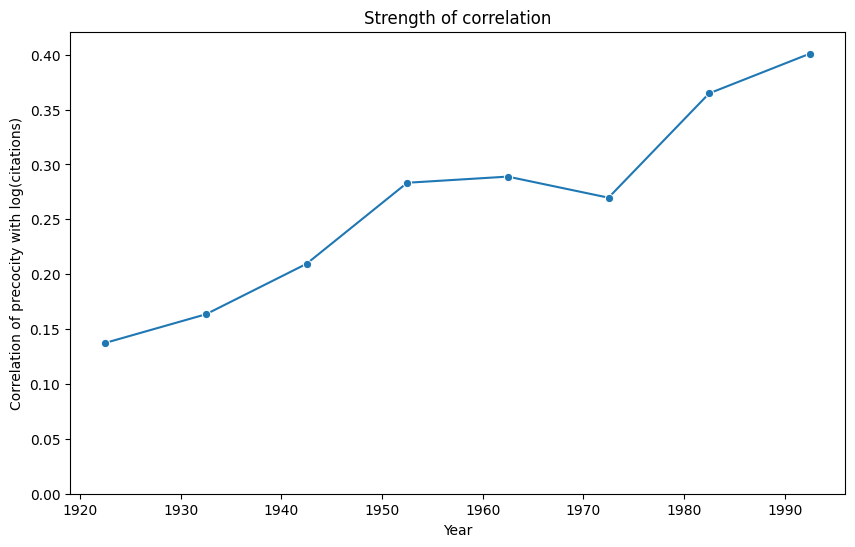

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     187.0
Date:                Fri, 05 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:13:36   Log-Likelihood:                -22502.
No. Observations:               15715   AIC:                         4.504e+04
Df Residuals:                   15695   BIC:                         4.520e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7223      0.097      7.444      

In [6]:
reg_df = run_model('../topicmodel/flatresults/precocity_flat_', rschmeta, chunksused = 0.25, fractioncompared = 1.0)

In [7]:
topic_rsch = reg_df.copy()
topic_rsch.set_index('docid', inplace=True)

**Null model**

We should also run a null model for research articles, since the effect of date might be different.

In [27]:
null_reg_df = reg_df.copy()
null_reg_df['precocity'] = 0
null_reg_df['novelty'] = 0
controlled_model(null_reg_df)

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     107.9
Date:                Fri, 05 Jul 2024   Prob (F-statistic):               0.00
Time:                        20:57:50   Log-Likelihood:                -23286.
No. Observations:               15715   AIC:                         4.661e+04
Df Residuals:                   15698   BIC:                         4.674e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2213      0.027     45.296      

Date is more powerfully explanatory for research articles, but our model is still explaining much more variance here than in the full dataset.

Before moving to other models, let's briefly consider other ways of measuring similarity. For instance, what if we use all the chunks from each article instead of the top 25%?

1920 20/0.25/1.0 topics no auth overlaps or text reuse 0.07035
1930 20/0.25/1.0 topics no auth overlaps or text reuse 0.09733
1940 20/0.25/1.0 topics no auth overlaps or text reuse 0.17619
1950 20/0.25/1.0 topics no auth overlaps or text reuse 0.25809
1960 20/0.25/1.0 topics no auth overlaps or text reuse 0.27363
1970 20/0.25/1.0 topics no auth overlaps or text reuse 0.2523
1980 20/0.25/1.0 topics no auth overlaps or text reuse 0.32276
1990 20/0.25/1.0 topics no auth overlaps or text reuse 0.3528


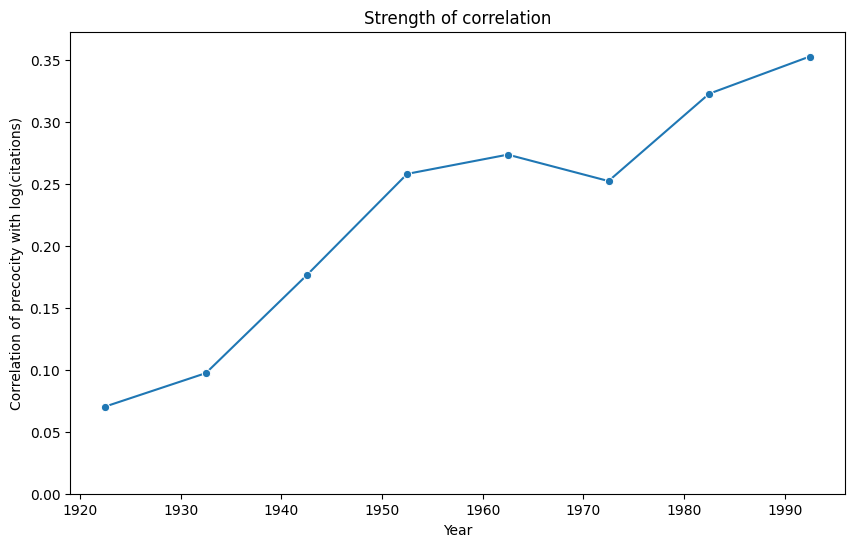

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     2630.
Date:                Fri, 28 Jun 2024   Prob (F-statistic):               0.00
Time:                        08:59:22   Log-Likelihood:            -3.6290e+05
No. Observations:              251440   AIC:                         7.258e+05
Df Residuals:                  251420   BIC:                         7.260e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0414      0.025     41.582      

In [49]:
reg_df = run_model('../topicmodel/flatresults/precocity_flat_', rschmeta, chunksused = 1.0, fractioncompared = 1.0)

Hmm. That was less effective. What if we only compare to the top 5% of most similar chunks?

1920 20/0.25/1.0 topics no auth overlaps or text reuse 0.05754
1930 20/0.25/1.0 topics no auth overlaps or text reuse 0.03963
1940 20/0.25/1.0 topics no auth overlaps or text reuse 0.1583
1950 20/0.25/1.0 topics no auth overlaps or text reuse 0.22898
1960 20/0.25/1.0 topics no auth overlaps or text reuse 0.25589
1970 20/0.25/1.0 topics no auth overlaps or text reuse 0.33389
1980 20/0.25/1.0 topics no auth overlaps or text reuse 0.36923
1990 20/0.25/1.0 topics no auth overlaps or text reuse 0.39926


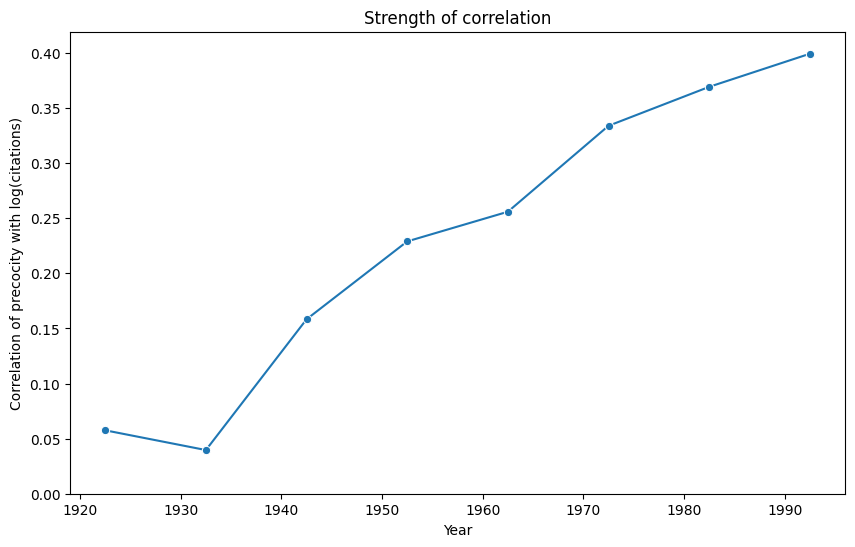

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     2349.
Date:                Fri, 28 Jun 2024   Prob (F-statistic):               0.00
Time:                        09:00:38   Log-Likelihood:            -3.6514e+05
No. Observations:              251440   AIC:                         7.303e+05
Df Residuals:                  251420   BIC:                         7.305e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1597      0.023     50.756      

In [50]:
reg_df = run_model('../topicmodel/flatresults/precocity_flat_', rschmeta, chunksused = 0.25, fractioncompared = .05)

Also less effective, especially in the early going where our corpus is small. It gets more competitive with larger corpora, but still not as good as `0.25` and `1.0`. In a full discussion we might also pause here to discuss the effects of different exclusions, train, auth, and quote, but I've recently sent an email about that and I want to keep this notebook readable so let's continue to other models.

### Embeddings trained on citation pairs

I'm going to continue to compare models to the research-article subset, but the differences are broadly parallel in the full dataset.

In principle we would expect this model to produce embeddings that are good at measuring a kind of similarity related to citations, but performance is uneven.

Note that I forgot to exclude the training set when I ran this. I'll re-run, but we would expect the effect of that to be slight and in a positive direction. 

1920 20/0.25/1.0 topics no auth overlaps or text reuse 0.14104
1930 20/0.25/1.0 topics no auth overlaps or text reuse 0.09686
1940 20/0.25/1.0 topics no auth overlaps or text reuse 0.18292
1950 20/0.25/1.0 topics no auth overlaps or text reuse 0.28586
1960 20/0.25/1.0 topics no auth overlaps or text reuse 0.2678
1970 20/0.25/1.0 topics no auth overlaps or text reuse 0.27792
1980 20/0.25/1.0 topics no auth overlaps or text reuse 0.23725
1990 20/0.25/1.0 topics no auth overlaps or text reuse -0.00875


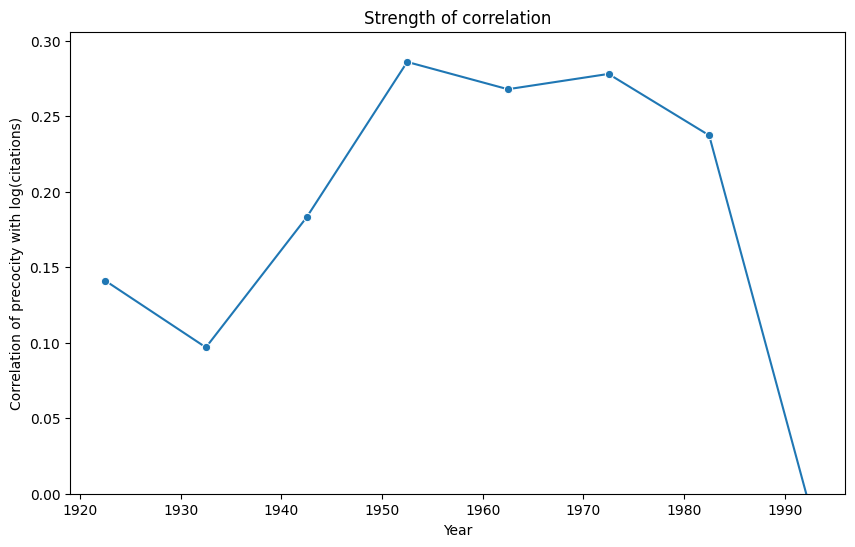

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     1797.
Date:                Fri, 28 Jun 2024   Prob (F-statistic):               0.00
Time:                        09:06:27   Log-Likelihood:            -3.6968e+05
No. Observations:              251440   AIC:                         7.394e+05
Df Residuals:                  251420   BIC:                         7.396e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2492      0.012    102.124      

In [51]:
reg_df = run_model('../tunedembeddings/citeresults/citation_model_', rschmeta, chunksused = 0.25, fractioncompared = 1.0)

This model performs best in the center of the timeline, outperforming the topic model in the 1950s and 1960s, but not in the 70s or 80s. Correlation with citations is actually negative in the 1990s. Novelty is a positive variable in this model.

### Embeddings trained in an unsupervised way with multiple negatives ranking loss

We're looking at the third model we trained using MNRL. Basically, that means we fine-tuned the embeddings (drawn from Roberta, with 512-token context length) positive pairs that are adjacent passages from the same article, and the negatives are all other possible pairings in a batch.

As I explained in email, this one is trained on a dataset where 18% of the pairs were paraphrased by GPT-3.5, and that seems to outperform models with 0% or 9% paraphrase. Some of these pairs are passage A + a paraphrase of the adjacent passage B. Others are A + a paraphrase of A.

1920 - 20/0.25/1.0, n = 1357, 0.2197
1930 - 20/0.25/1.0, n = 1917, 0.21781
1940 - 20/0.25/1.0, n = 1832, 0.12504
1950 - 20/0.25/1.0, n = 2046, 0.28079
1960 - 20/0.25/1.0, n = 2020, 0.20497
1970 - 20/0.25/1.0, n = 2449, 0.241
1980 - 20/0.25/1.0, n = 2395, 0.27151
1990 - 20/0.25/1.0, n = 1699, 0.3531


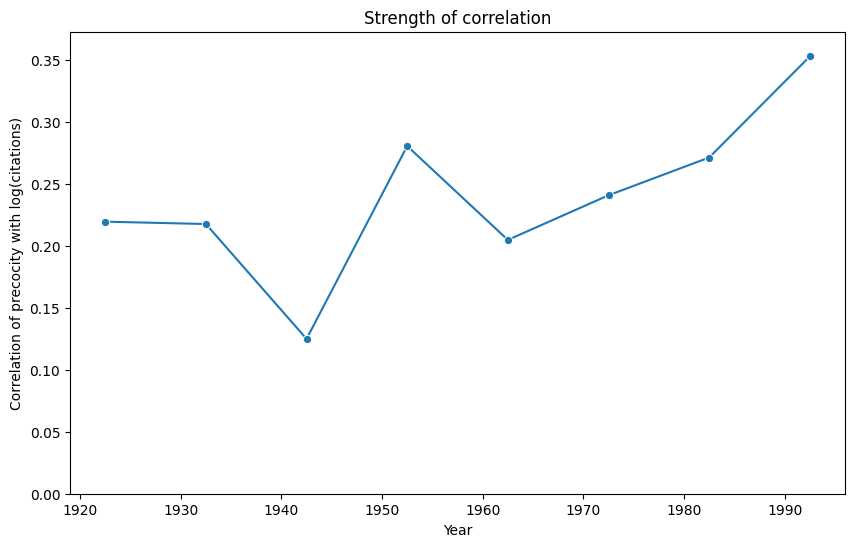

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     168.3
Date:                Fri, 05 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:13:57   Log-Likelihood:                -22648.
No. Observations:               15715   AIC:                         4.534e+04
Df Residuals:                   15695   BIC:                         4.549e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8298      0.030     27.510      

In [8]:
reg_df = run_model('../tunedembeddings/para20/para20_', rschmeta, chunksused = 0.25, fractioncompared = 1.0)

In [9]:
embed_rsch = reg_df.copy()
embed_rsch.set_index('docid', inplace=True)

#### How well do embeddings perform on all chunks of a document?

1920 - 20/1.0/1.0 no auth overlaps or text reuse 0.19675
1930 - 20/1.0/1.0 no auth overlaps or text reuse 0.21019
1940 - 20/1.0/1.0 no auth overlaps or text reuse 0.10658
1950 - 20/1.0/1.0 no auth overlaps or text reuse 0.25742
1960 - 20/1.0/1.0 no auth overlaps or text reuse 0.17651
1970 - 20/1.0/1.0 no auth overlaps or text reuse 0.18809
1980 - 20/1.0/1.0 no auth overlaps or text reuse 0.18676
1990 - 20/1.0/1.0 no auth overlaps or text reuse 0.27999


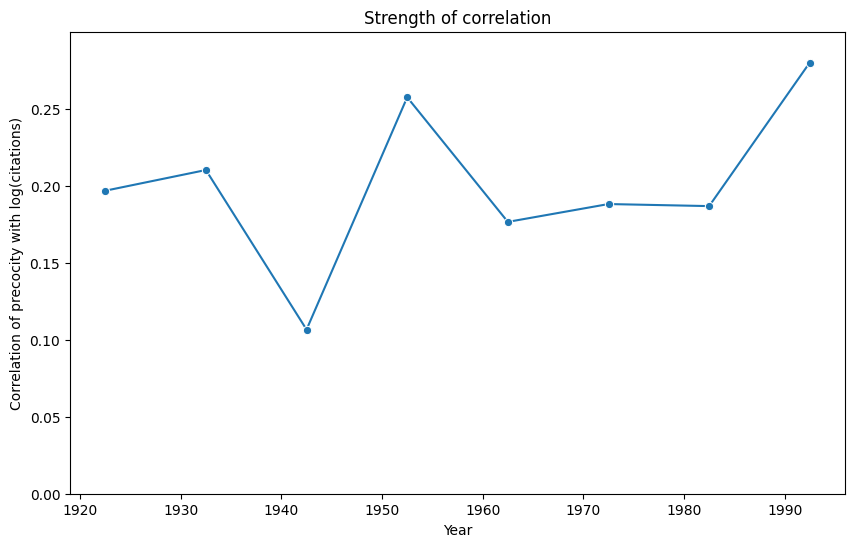

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     2306.
Date:                Sun, 30 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:55:48   Log-Likelihood:            -3.6549e+05
No. Observations:              251440   AIC:                         7.310e+05
Df Residuals:                  251420   BIC:                         7.312e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0157      0.008    132.922      

In [223]:
reg_df = run_model('../tunedembeddings/para20/para20_', rschmeta, chunksused = 1.0, fractioncompared = 1.0)

These embeddings are stronger than the topic model in the 1920s and 30s, but still weaker overall. The gap between these embeddings and the topic model is slightly smaller if we look at the full dataset, but the topic model is still on top.

**An open question:** Given this evidence, how confident are we that citations correlate more strongly with precocity in recent decades?

### Perplexity comparisons

[Vicinanza 2022](https://doi-org.proxy2.library.illinois.edu/10.1093/pnasnexus/pgac275) offers a different way of measuring a work's "prescience," or relation to the future.

How well does this predict log(citations)?

The original Vicinanza article just measures "prescience": perplexity in the present minus perplexity in the future. This is kind of the reverse of "transcience": it will be high when the patterns represented in a text are more common in the future than in the present.

This measure does not perform well at all, but we can adjust it by adding a relation to the past. Again, measuring perplexity makes this the reverse of a distance measure. If perplexity in the past is lower than in the present, we can say this pattern was more common in the past. Let's call it not "novelty" but "nostalgia."

If we subtract nostalgia from prescience, we get the equivalent of precocity — a measure that will be high when a text is more like the future than the past. A simpler way to measure this is just, perplexity in the past minus perplexity in the future, normalized by the average of the two values.

Our models are located 12 years apart, so this ends up measuring change over ~24 years. The total span of 36 years is comparable to the total 41-year span of our other calculation.



In [13]:
from glob import glob
resfiles = glob('../perplexity/results/CN*.tsv')
resfiles

['../perplexity/results/CNsFrom1968To1971.tsv',
 '../perplexity/results/CNsFrom1928To1931.tsv',
 '../perplexity/results/CNsFrom1956To1959.tsv',
 '../perplexity/results/CNsFrom1988To1991.tsv',
 '../perplexity/results/CNsFrom1940To1943.tsv',
 '../perplexity/results/CNsFrom1924To1927.tsv',
 '../perplexity/results/CNsFrom1964To1967.tsv',
 '../perplexity/results/CNsFrom1952To1955.tsv',
 '../perplexity/results/CNsFrom1984To1987.tsv',
 '../perplexity/results/CNsFrom1948To1951.tsv',
 '../perplexity/results/CNsFrom1976To1979.tsv',
 '../perplexity/results/CNsFrom1936To1939.tsv',
 '../perplexity/results/CNsFrom1960To1963.tsv',
 '../perplexity/results/CNsFrom1920To1923.tsv',
 '../perplexity/results/CNsFrom1992To1995.tsv',
 '../perplexity/results/CNsFrom1944To1947.tsv',
 '../perplexity/results/CNsFrom1980To1983.tsv',
 '../perplexity/results/CNsFrom1972To1975.tsv',
 '../perplexity/results/CNsFrom1932To1935.tsv']

In [10]:
def pivot_results(results):
    results = results.rename(columns={'index': 'chunknum'})

    # Create a dict that will map paperIds to years
    year_dict = dict(zip(results.paperId, results.year))

    # Assuming your data frame is named 'results'
    # Create a new column that combines paperId and chunknum
    results['index'] = results['paperId'] + '_' + results['chunknum'].astype(str)

    # Pivot the data frame using the index
    wide_results = pd.pivot_table(results, values='perplexity', index='index', columns='model', aggfunc='first')
    wide_results.reset_index(inplace=True)
    # Separate the index column back into paperId and chunknum
    wide_results[['paperId', 'chunknum']] = wide_results['index'].str.split('_', expand=True)
    # drop the index column
    wide_results.drop(columns='index', inplace=True)
    # Recreate the year column
    wide_results['year'] = wide_results['paperId'].map(year_dict)
    return wide_results

In [11]:
def get_perplexity_correlations(resfile, meta, chunksused = 1.0):
    results = pd.read_csv(resfile, sep = '\t')
    
    results = pivot_results(results)

    yearpart = resfile.replace('../perplexity/results/CNsFrom', '').replace('.tsv','')
    yr = int(yearpart[0:4])
    presentcol = 'model' + str(yr -4) + '-' + str(yr + 7)
    futurecol = 'model' + str(yr + 8) + '-' + str(yr + 19)
    pastcol = 'model' + str(yr - 16) + '-' + str(yr - 5)

    results['present-future'] = (results[presentcol] - results[futurecol]) / results[presentcol]
    results['present-past'] = results[presentcol] - results[pastcol] / results[presentcol]
    results['past-future'] = (results[pastcol] - results[futurecol]) / ((results[pastcol] + results[futurecol]) / 2)

    paperIds = []
    presentminusfuture = []
    presentminuspast = []
    pastminusfuture = []
    years = []

    for paperId, group in results.groupby('paperId'):
        paperIds.append(paperId)
        n = math.ceil(len(group) * chunksused)
        sorted_group = group.sort_values('present-future', ascending=False)
        top_n_rows = sorted_group.head(n)
        presentminusfuture.append(top_n_rows['present-future'].mean())
        sorted_group = group.sort_values('present-past', ascending=True)   # because low values are good
        top_n_rows = sorted_group.head(n)
        presentminuspast.append(top_n_rows['present-past'].mean())
        sorted_group = group.sort_values('past-future', ascending=False)
        top_n_rows = sorted_group.head(n)
        pastminusfuture.append(top_n_rows['past-future'].mean())
        years.append(group['year'].iloc[0])
    
    bypaper = pd.DataFrame({'docid': paperIds, 'presentminusfuture': presentminusfuture,
                             'presentminuspast': presentminuspast, 'pastminusfuture': pastminusfuture,
                             'year': years})
    bypaper.set_index('docid', inplace=True)
    data = bypaper.join(meta['new_cite_count'], how='inner')
    data['logcitations'] = np.log(data.new_cite_count + 1)
    
    print()
    print(yr)
    print(data.shape)
    print('present minus future', pearsonr(data['presentminusfuture'], data['logcitations']))
    print('present minus past', pearsonr(data['presentminuspast'], data['logcitations']))
    print('past minus future', pearsonr(data['pastminusfuture'], data['logcitations']))
    r, p = pearsonr(data['pastminusfuture'], data['logcitations'])

    precocity = data['pastminusfuture']
    novelty = data['presentminuspast']    # really nostalgia, but the change of sign is okay in a regression
    date = data['year']
    logcitations = data['logcitations']

    reg_df = pd.DataFrame({'precocity': precocity, 'novelty': novelty, 'prescience': data['presentminusfuture'],
                            'date': date, 'logcitations': logcitations, 'docid': data.index.tolist()})

    return r, yr, reg_df


1968
(873, 6)
present minus future PearsonRResult(statistic=0.08481259150895201, pvalue=0.012181274304439521)
present minus past PearsonRResult(statistic=-0.06022683939483971, pvalue=0.07531163403112108)
past minus future PearsonRResult(statistic=0.1335011087623769, pvalue=7.6032997364062e-05)

1928
(715, 6)
present minus future PearsonRResult(statistic=-0.05233091545546817, pvalue=0.16216976028222077)
present minus past PearsonRResult(statistic=-0.041096448383815556, pvalue=0.27244963016303314)
past minus future PearsonRResult(statistic=-0.03634779317151243, pvalue=0.33177668875183014)

1956
(830, 6)
present minus future PearsonRResult(statistic=-0.040550694979589685, pvalue=0.24322104649790613)
present minus past PearsonRResult(statistic=-0.0924177062327129, pvalue=0.007716724107482993)
past minus future PearsonRResult(statistic=0.266194754807335, pvalue=6.261116963559201e-15)

1988
(990, 6)
present minus future PearsonRResult(statistic=0.11920471811194784, pvalue=0.0001703470444969

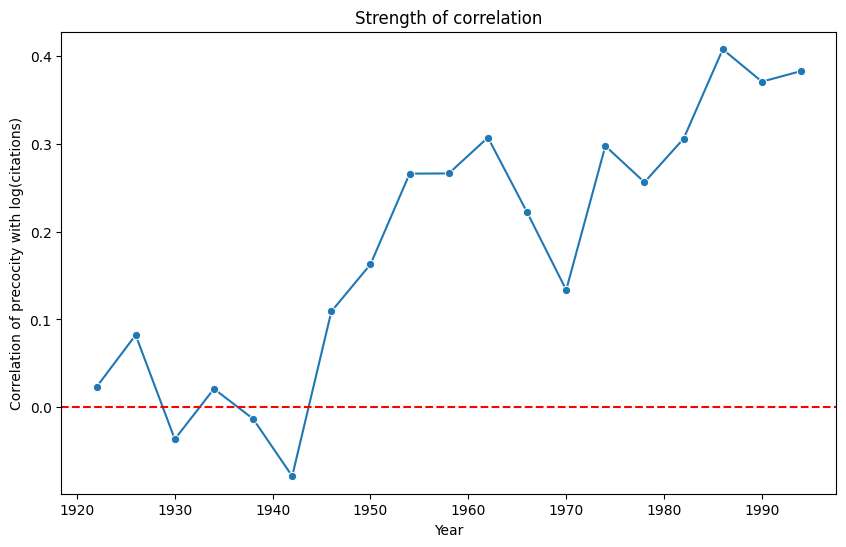

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     132.8
Date:                Fri, 05 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:14:36   Log-Likelihood:                -22487.
No. Observations:               15459   AIC:                         4.501e+04
Df Residuals:                   15439   BIC:                         4.517e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2174      0.029     41.615      

In [14]:
perplexity_correlations = []
perplexity_years = []
reg_dfs = []

for resfile in resfiles:
    r, yr, reg_df = get_perplexity_correlations(resfile, rschmeta, chunksused = 1.0)
    perplexity_correlations.append(r)
    perplexity_years.append(yr)
    reg_dfs.append(reg_df)

visualize_results(perplexity_correlations, np.array(perplexity_years) + 2)
controlled_model(pd.concat(reg_dfs))


#### How would Vicinanza's original model have performed on this data?

We can find out by taking out all evidence about the past. The answer is: badly.

In [230]:
reg_df = pd.concat(reg_dfs)
reg_df['precocity'] = reg_df['prescience']
reg_df['novelty'] = 0
controlled_model(reg_df)

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     1694.
Date:                Sun, 30 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:27:28   Log-Likelihood:            -3.6414e+05
No. Observations:              247344   AIC:                         7.283e+05
Df Residuals:                  247325   BIC:                         7.285e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2701      0.007    180.218      

**Does using the top quarter of results outperform here as it did with the other models?**

Yes, it helps.


1968
(873, 6)
present minus future PearsonRResult(statistic=0.13236894013264597, pvalue=8.75555327790195e-05)
present minus past PearsonRResult(statistic=-0.029283332128645298, pvalue=0.3874957373326771)
past minus future PearsonRResult(statistic=0.17488781223714495, pvalue=1.992260508114923e-07)

1928
(715, 6)
present minus future PearsonRResult(statistic=-0.010717919363794194, pvalue=0.7748027476887066)
present minus past PearsonRResult(statistic=-0.10144298523483977, pvalue=0.006631716231343193)
past minus future PearsonRResult(statistic=0.002139918219894881, pvalue=0.9544493990986337)

1956
(830, 6)
present minus future PearsonRResult(statistic=0.049382256751286546, pvalue=0.1551969619296018)
present minus past PearsonRResult(statistic=-0.0732739355931004, pvalue=0.03480171948980206)
past minus future PearsonRResult(statistic=0.2773885324005514, pvalue=3.9625504519006687e-16)

1988
(990, 6)
present minus future PearsonRResult(statistic=0.19695370707783297, pvalue=4.091521690935813

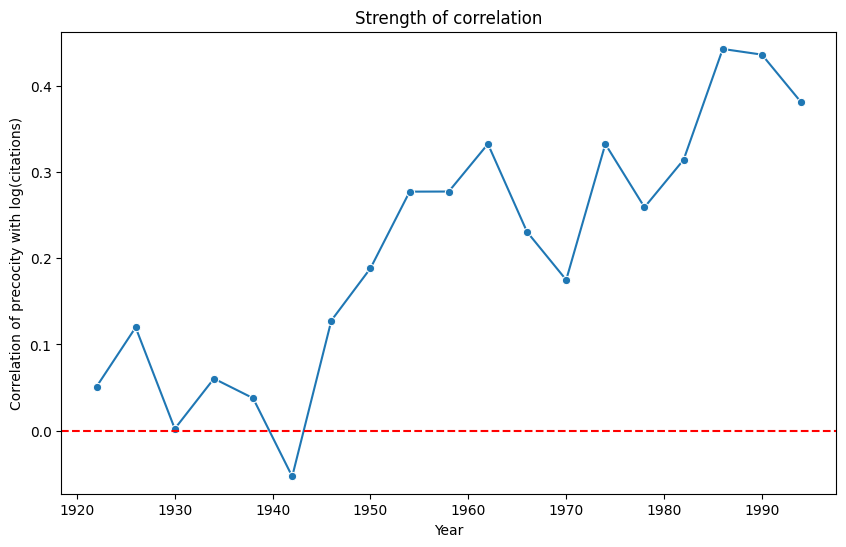

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     150.0
Date:                Fri, 05 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:45:05   Log-Likelihood:                -22348.
No. Observations:               15459   AIC:                         4.474e+04
Df Residuals:                   15439   BIC:                         4.489e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8879      0.034     26.202      

In [30]:
perplexity_correlations = []
perplexity_years = []
reg_dfs = []

for resfile in resfiles:
    r, yr, reg_df = get_perplexity_correlations(resfile, rschmeta, chunksused = 0.25)
    perplexity_correlations.append(r)
    perplexity_years.append(yr)
    reg_dfs.append(reg_df)

visualize_results(perplexity_correlations, np.array(perplexity_years) + 2)
controlled_model(pd.concat(reg_dfs))

Note that a null model for the perplexity data is just a hair stronger, because we have slightly fewer rows.

In [31]:
null_reg_df = pd.concat(reg_dfs)
null_reg_df['precocity'] = 0
null_reg_df['novelty'] = 0
controlled_model(null_reg_df)

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     107.7
Date:                Fri, 05 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:46:03   Log-Likelihood:                -22840.
No. Observations:               15459   AIC:                         4.571e+04
Df Residuals:                   15442   BIC:                         4.584e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1865      0.028     43.057      

In [16]:
perplexity_rsch = pd.concat(reg_dfs)
perplexity_rsch.set_index('docid', inplace=True)

**Interpretation**

Overall Vicinanza is not competitive, even after we improve it by a) adding comparison to the past and b) limiting to the top quarter of chunks.

But it does better on recent decades than on the early 20c. There may be a presentism bias inherited from the base Roberta model that our fine-tuning has not completely overcome. However, since we see the upward trend also in other methods, we need not conclude that it is entirely due to this bias.

It's notable that using the top quarter of chunks improves this metric's correlation with citations, as it improves all the others.


### How much do the three methods of calculating precocity correlate with each other?

In [25]:
def compare_correlations(df1, df2):
	correlating_df = df1.join(df2, lsuffix='_1', rsuffix='_2', how = 'inner')

	print('Sanity check:', pearsonr(correlating_df['logcitations_1'], correlating_df['logcitations_2']))
	r, p = pearsonr(correlating_df['precocity_1'], correlating_df['precocity_2'])
	print('precocity ranking (r, r2, p):', r, r**2, p)

compare_correlations(topic_rsch, perplexity_rsch)
print()
compare_correlations(embed_rsch, perplexity_rsch)
print()
compare_correlations(topic_rsch, embed_rsch)

print(topic_rsch.shape)
print(embed_rsch.shape)
print(perplexity_rsch.shape)

Sanity check: PearsonRResult(statistic=0.9999999999999653, pvalue=0.0)
precocity ranking (r, r2, p): 0.0544308644738686 0.0029627190073726506 1.2693290509996539e-11

Sanity check: PearsonRResult(statistic=0.9999999999999653, pvalue=0.0)
precocity ranking (r, r2, p): 0.2620990965152777 0.06869593639412484 3.25212100827087e-241

Sanity check: PearsonRResult(statistic=0.999999999999966, pvalue=0.0)
precocity ranking (r, r2, p): 0.6585129614033243 0.433639320336176 0.0
(15715, 4)
(15715, 4)
(15459, 5)


The weak correlation between the topic model and perplexity methods implies that it ought to be possible to combine them to produce better predictions — and indeed, it is.

In [29]:
combined_model = topic_rsch.copy()
combined_model.drop(columns=['novelty'], inplace=True)
combined_model['novelty'] = perplexity_rsch['precocity']
combined_model.dropna(subset=['novelty'], inplace=True)
controlled_model(combined_model)

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     193.8
Date:                Fri, 05 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:43:02   Log-Likelihood:                -22004.
No. Observations:               15459   AIC:                         4.405e+04
Df Residuals:                   15439   BIC:                         4.420e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5619      0.033     16.916      

## Author age

We have birth years for 71 prolific authors, and thus author age for about 3000 articles.

In [7]:
agedata = pd.read_csv('../becca/papers_with_age.tsv', sep = '\t')
agedata['docid'] = agedata.paperId
agedata.set_index('docid', inplace=True)
print(agedata.shape)

(3389, 19)


**Our hypothesis is that youth is negatively correlated with citation frequency. Is this true?**

A negative correlation with youth will of course take the form of a positive correlation with age. And yes, it's true.

In [8]:
agedata['logcitations'] = np.log(agedata.new_cite_count + 1)
pearsonr(agedata['age'], agedata['logcitations'])

PearsonRResult(statistic=0.048806043910736764, pvalue=0.004484624998358175)

#### How well do the topic model and MNRL embedding model predict youth?

In [10]:
def age_model(reg_df):
	
	X = []
	for idx, row in reg_df.iterrows():
		newrow = dict()
		newrow['precocity'] = row['precocity']
		newrow['novelty'] = row['novelty']
		newrow['precocity^2'] = row['precocity'] ** 2
		newrow['ages'] = row['ages']
		for yr in range(1920, 2000, 10):
			col = 'year' + str(yr)
			if (row['date'] >= yr) and (row['date'] <= yr + 9):
				newrow[col] = 1
			else:
				newrow[col] = 0
		X.append(newrow)

	X = pd.DataFrame(X)

	# Add a constant to the model (the intercept)
	X = sm.add_constant(X)

	# Define the dependent variable
	y = X['ages']

	X = X.drop('ages', axis=1)

	# Fit the linear regression model
	model = sm.OLS(y, X).fit()

	# Print the summary of the model
	print(model.summary())

**First we define a function and run it on the topic model.**

In [11]:
def run_age_model(path_to_model, metadata, chunksused = 0.25, fractioncompared = 1.0):
    precocity = []
    novelty = []
    date = []
    ages = []
    citations = []

    for decade in range(1920, 2000, 10):
        
        data = pd.read_csv(path_to_model + str(decade) + 's_docs.tsv', sep = '\t')
        data['docid'] = data['docid'].astype(str)
        data.set_index('docid', inplace=True)
        data = data.join(metadata['age'], how='inner')
        data = data.join(metadata['new_cite_count'], how = 'inner')
    

        selected = data.loc[(data.time_radius == 20) & (data.filtered == 'trainauthquote') &
            (data.chunks_used == chunksused) & (data.fraction_compared == fractioncompared), :]
        
        r, p = pearsonr(selected.age, selected.precocity)
        print(decade, round(r, 5))

        precocity.extend(selected.precocity.values.tolist())
        novelty.extend(selected.novelty.values.tolist())
        date.extend(selected.date.values.tolist())
        ages.extend(selected.age.values.tolist())
        citations.extend(selected.new_cite_count.values.tolist())
    
    reg_df = pd.DataFrame({'precocity': precocity, 'novelty': novelty, 'date': date, 
                           'ages': ages, 'citations': citations})

    return reg_df

reg_df = run_age_model('../topicmodel/flatresults/precocity_flat_', agedata, chunksused = 0.25, fractioncompared = 1.0)
age_model(reg_df)

1920 -0.00317
1930 -0.199
1940 0.09054
1950 0.02634
1960 -0.16795
1970 -0.23795
1980 -0.2669
1990 -0.17725
                            OLS Regression Results                            
Dep. Variable:                   ages   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     17.01
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           2.81e-30
Time:                        19:37:17   Log-Likelihood:                -10350.
No. Observations:                2673   AIC:                         2.072e+04
Df Residuals:                    2662   BIC:                         2.079e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [169]:
agedata.columns

Index(['paperId', 'doi', 'journal', 'year', 'authors', 'title', 'language',
       'wordcount', 'doctype', 'citation_counts', 'S2titles', 'S2years',
       'condition', 'matchstrength', 'S2journal', 'S2authors',
       'new_cite_count', 'make_embeddings', 'age', 'logcitations'],
      dtype='object')

**Note that using all chunks works (slightly) better here than using the top 25%. This is a difference from the citation task.**

In [14]:
reg_df = run_age_model('../topicmodel/flatresults/precocity_flat_', agedata, chunksused = 1.0, fractioncompared = 1.0)
age_model(reg_df)

1920 0.03529
1930 -0.23839
1940 0.0803
1950 0.01776
1960 -0.15303
1970 -0.2253
1980 -0.30857
1990 -0.2388
                            OLS Regression Results                            
Dep. Variable:                   ages   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     17.49
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           3.29e-31
Time:                        19:38:12   Log-Likelihood:                -10348.
No. Observations:                2673   AIC:                         2.072e+04
Df Residuals:                    2662   BIC:                         2.078e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

### Null model

In [15]:
reg_df['precocity'] = 0
reg_df['novelty'] = 0
age_model(reg_df)

                            OLS Regression Results                            
Dep. Variable:                   ages   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     12.27
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           2.21e-17
Time:                        19:38:31   Log-Likelihood:                -10384.
No. Observations:                2673   AIC:                         2.079e+04
Df Residuals:                    2664   BIC:                         2.084e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.107e+11   3.88e+12      0.157      

#### How well does the embedding model predict youth?

It doesn't perform as well.

In [21]:
reg_df = run_age_model('../tunedembeddings/para20/para20_', agedata, chunksused = 1.0, fractioncompared = 1.0)
age_model(reg_df)

1920 0.15657
1930 -0.33798
1940 0.02827
1950 0.16366
1960 0.02369
1970 -0.05563
1980 -0.24825
1990 -0.16752
                            OLS Regression Results                            
Dep. Variable:                   ages   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     11.13
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           7.68e-19
Time:                        19:42:03   Log-Likelihood:                -10378.
No. Observations:                2673   AIC:                         2.078e+04
Df Residuals:                    2662   BIC:                         2.084e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------

In [17]:
reg_df = run_age_model('../tunedembeddings/para20/para20_', agedata, chunksused = 0.25, fractioncompared = 1.0)
age_model(reg_df)

1920 0.16727
1930 -0.28496
1940 0.0625
1950 0.17609
1960 0.01841
1970 -0.04197
1980 -0.21377
1990 -0.14909
                            OLS Regression Results                            
Dep. Variable:                   ages   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     10.52
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           1.17e-17
Time:                        19:39:34   Log-Likelihood:                -10381.
No. Observations:                2673   AIC:                         2.078e+04
Df Residuals:                    2662   BIC:                         2.085e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

### How well does the Vicinanza / perplexity approach predict youth?

In [18]:
def perplexity_age(resfile, meta, chunksused = 1.0):
    results = pd.read_csv(resfile, sep = '\t')

    results = pivot_results(results)

    yearpart = resfile.replace('../perplexity/results/CNsFrom', '').replace('.tsv','')
    yr = int(yearpart[0:4])
    presentcol = 'model' + str(yr -4) + '-' + str(yr + 7)
    futurecol = 'model' + str(yr + 8) + '-' + str(yr + 19)
    pastcol = 'model' + str(yr - 16) + '-' + str(yr - 5)

    results['present-future'] = (results[presentcol] - results[futurecol]) / results[presentcol]
    results['present-past'] = results[presentcol] - results[pastcol] / results[presentcol]
    results['past-future'] = (results[pastcol] - results[futurecol]) / ((results[pastcol] + results[futurecol]) / 2)

    paperIds = []
    presentminusfuture = []
    presentminuspast = []
    pastminusfuture = []
    years = []

    for paperId, group in results.groupby('paperId'):
        paperIds.append(paperId)
        n = math.ceil(len(group) * chunksused)
        sorted_group = group.sort_values('present-future', ascending=False)
        top_n_rows = sorted_group.head(n)
        presentminusfuture.append(top_n_rows['present-future'].mean())
        sorted_group = group.sort_values('present-past', ascending=True)   # because low values are good
        top_n_rows = sorted_group.head(n)
        presentminuspast.append(top_n_rows['present-past'].mean())
        sorted_group = group.sort_values('past-future', ascending=False)
        top_n_rows = sorted_group.head(n)
        pastminusfuture.append(top_n_rows['past-future'].mean())
        years.append(group['year'].iloc[0])
    
    bypaper = pd.DataFrame({'docid': paperIds, 'presentminusfuture': presentminusfuture,
                             'presentminuspast': presentminuspast, 'pastminusfuture': pastminusfuture,
                             'year': years})
    bypaper.set_index('docid', inplace=True)
    
    data = bypaper.join(meta['age'], how='inner')
    data = data.join(meta['new_cite_count'], how='inner')

    precocity = data['pastminusfuture']
    novelty = data['presentminuspast']    # really nostalgia, but the change of sign is okay in a regression
    date = data['year']
    ages = data['age']
    citations = data['new_cite_count']

    reg_df = pd.DataFrame({'precocity': precocity, 'novelty': novelty, 'date': date, \
        'ages': ages, 'citations': citations})

    return reg_df

**First let's try using all the chunks. That performed best with other models.**

In [24]:
reg_dfs = []

for resfile in resfiles:
    reg_df = perplexity_age(resfile, agedata, chunksused = 1.0)
    reg_dfs.append(reg_df)

age_model(pd.concat(reg_dfs))

                            OLS Regression Results                            
Dep. Variable:                   ages   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     24.40
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           1.46e-44
Time:                        19:42:47   Log-Likelihood:                -10142.
No. Observations:                2629   AIC:                         2.031e+04
Df Residuals:                    2618   BIC:                         2.037e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          49.1518      0.457    107.563      

Vicinanza is giving the best results for age prediction.
    
**If we use the top quarter of the chunks, that again does not improve age prediction, although it did consistently help all three methods predict citation.**

In [25]:
reg_dfs = []

for resfile in resfiles:
    reg_df = perplexity_age(resfile, agedata, chunksused = .25)
    reg_dfs.append(reg_df)

age_model(pd.concat(reg_dfs))

                            OLS Regression Results                            
Dep. Variable:                   ages   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     18.86
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           7.57e-34
Time:                        19:44:40   Log-Likelihood:                -10168.
No. Observations:                2629   AIC:                         2.036e+04
Df Residuals:                    2618   BIC:                         2.042e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          51.9034      0.666     77.900      

## One last thought. What if we reversed this, and used age and citations to predict textual precocity?

In [252]:
def reverse_model(reg_df):

	reg_df = reg_df.drop('novelty', axis=1)
	
	X = []
	for idx, row in reg_df.iterrows():
		newrow = dict()
		newrow['precocity'] = row['precocity']
		if not pd.isnull(row['ages']):
			newrow['age'] = row['ages']
			newrow['age^2'] = row['ages'] ** 2
		if not pd.isnull(row['citations']):
			newrow['citations'] = row['citations']
			newrow['logcitations'] = np.log(row['citations'] + 1)
		for yr in range(1920, 1995, 4):
			col = 'year' + str(yr)
			if (row['date'] >= yr) and (row['date'] <= yr + 5):
				newrow[col] = 1
			else:
				newrow[col] = 0
		X.append(newrow)

	X = pd.DataFrame(X)

	# Add a constant to the model (the intercept)
	X = sm.add_constant(X)

	# Define the dependent variable
	y = X['precocity']

	X = X.drop('precocity', axis=1)

	# Fit the linear regression model
	model = sm.OLS(y, X).fit()

	# Print the summary of the model
	print(model.summary())

In [256]:
reg_df = run_age_model('../topicmodel/flatresults/precocity_flat_', agedata, chunksused = 0.25, fractioncompared = 1.0)
reverse_model(reg_df)

1920 0.00166
1930 -0.20275
1940 0.08537
1950 0.0281
1960 -0.10866
1970 -0.22223
1980 -0.25873
1990 -0.18421
                            OLS Regression Results                            
Dep. Variable:              precocity   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     259.1
Date:                Mon, 01 Jul 2024   Prob (F-statistic):               0.00
Time:                        08:55:52   Log-Likelihood:                 3061.8
No. Observations:                2404   AIC:                            -6076.
Df Residuals:                    2380   BIC:                            -5937.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [258]:
# Null model for these precocity scores
reg_df['citations'] = float('nan')
reg_df['ages'] = float('nan')
reverse_model(reg_df)

                            OLS Regression Results                            
Dep. Variable:              precocity   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     299.3
Date:                Mon, 01 Jul 2024   Prob (F-statistic):               0.00
Time:                        08:56:35   Log-Likelihood:                 3020.6
No. Observations:                2404   AIC:                            -6001.
Df Residuals:                    2384   BIC:                            -5885.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1674      0.005     37.011      0.0

In [259]:
reg_df = run_age_model('../topicmodel/flatresults/precocity_flat_', agedata, chunksused = 1.0, fractioncompared = 1.0)
reverse_model(reg_df)

1920 0.04115
1930 -0.25811
1940 0.07374
1950 0.01679
1960 -0.11099
1970 -0.22756
1980 -0.30468
1990 -0.25572
                            OLS Regression Results                            
Dep. Variable:              precocity   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     333.0
Date:                Mon, 01 Jul 2024   Prob (F-statistic):               0.00
Time:                        08:57:24   Log-Likelihood:                 3421.5
No. Observations:                2404   AIC:                            -6795.
Df Residuals:                    2380   BIC:                            -6656.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [260]:
# Null model for these precocity scores
reg_df['citations'] = float('nan')
reg_df['ages'] = float('nan')
reverse_model(reg_df)

                            OLS Regression Results                            
Dep. Variable:              precocity   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     385.9
Date:                Mon, 01 Jul 2024   Prob (F-statistic):               0.00
Time:                        08:57:43   Log-Likelihood:                 3380.2
No. Observations:                2404   AIC:                            -6720.
Df Residuals:                    2384   BIC:                            -6605.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1363      0.004     34.998      0.0

#### Reverse model with embeddings

In [262]:
reg_df = run_age_model('../tunedembeddings/para20/para20_', agedata, chunksused = 0.25, fractioncompared = 1.0)
reverse_model(reg_df)


1920 0.17121
1930 -0.30141
1940 0.06343
1950 0.2013
1960 0.00101
1970 0.00663
1980 -0.20226
1990 -0.14192
                            OLS Regression Results                            
Dep. Variable:              precocity   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     47.34
Date:                Mon, 01 Jul 2024   Prob (F-statistic):          1.84e-175
Time:                        08:59:10   Log-Likelihood:                 7677.0
No. Observations:                2404   AIC:                        -1.531e+04
Df Residuals:                    2380   BIC:                        -1.517e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [263]:
# Null model for these precocity scores
reg_df['citations'] = float('nan')
reg_df['ages'] = float('nan')
reverse_model(reg_df)

                            OLS Regression Results                            
Dep. Variable:              precocity   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     51.32
Date:                Mon, 01 Jul 2024   Prob (F-statistic):          1.09e-161
Time:                        08:59:34   Log-Likelihood:                 7636.3
No. Observations:                2404   AIC:                        -1.523e+04
Df Residuals:                    2384   BIC:                        -1.512e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.001      8.034      0.0

In [264]:
# Using 1.0 for chunks used

reg_df = run_age_model('../tunedembeddings/para20/para20_', agedata, chunksused = 1.0, fractioncompared = 1.0)
reverse_model(reg_df)
null_model = reg_df.copy()

1920 0.16109
1930 -0.35627
1940 0.03002
1950 0.18881
1960 0.01288
1970 -0.03039
1980 -0.23532
1990 -0.15511
                            OLS Regression Results                            
Dep. Variable:              precocity   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     61.20
Date:                Mon, 01 Jul 2024   Prob (F-statistic):          3.90e-220
Time:                        09:00:03   Log-Likelihood:                 7885.3
No. Observations:                2404   AIC:                        -1.572e+04
Df Residuals:                    2380   BIC:                        -1.558e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [265]:
# Null model for these precocity scores
reg_df['citations'] = float('nan')
reg_df['ages'] = float('nan')
reverse_model(reg_df)

                            OLS Regression Results                            
Dep. Variable:              precocity   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     67.91
Date:                Mon, 01 Jul 2024   Prob (F-statistic):          1.96e-207
Time:                        09:00:18   Log-Likelihood:                 7846.8
No. Observations:                2404   AIC:                        -1.565e+04
Df Residuals:                    2384   BIC:                        -1.554e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.001     -3.722      0.0

In [266]:
# And Vicinanza

reg_dfs = []

for resfile in resfiles:
    reg_df = perplexity_age(resfile, agedata, chunksused = 0.25)
    reg_dfs.append(reg_df)
reg_df = pd.concat(reg_dfs)
reverse_model(reg_df)

                            OLS Regression Results                            
Dep. Variable:              precocity   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     51.24
Date:                Mon, 01 Jul 2024   Prob (F-statistic):          7.92e-188
Time:                        09:02:13   Log-Likelihood:                 2303.1
No. Observations:                2365   AIC:                            -4558.
Df Residuals:                    2341   BIC:                            -4420.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1817      0.032      5.658   

In [267]:
# Null model for these precocity scores
reg_df['citations'] = float('nan')
reg_df['ages'] = float('nan')
reverse_model(reg_df)

                            OLS Regression Results                            
Dep. Variable:              precocity   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     55.72
Date:                Mon, 01 Jul 2024   Prob (F-statistic):          1.04e-173
Time:                        09:02:27   Log-Likelihood:                 2261.5
No. Observations:                2365   AIC:                            -4483.
Df Residuals:                    2345   BIC:                            -4368.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1727      0.006     28.121      0.0

In [268]:
# And Vicinanza with 1.0 chunks used

reg_dfs = []

for resfile in resfiles:
    reg_df = perplexity_age(resfile, agedata, chunksused = 1.0)
    reg_dfs.append(reg_df)

reverse_model(pd.concat(reg_dfs))

                            OLS Regression Results                            
Dep. Variable:              precocity   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     74.73
Date:                Mon, 01 Jul 2024   Prob (F-statistic):          2.36e-259
Time:                        09:04:10   Log-Likelihood:                 2864.2
No. Observations:                2365   AIC:                            -5680.
Df Residuals:                    2341   BIC:                            -5542.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0481      0.025      1.900   

In [270]:
# And the null model?

# Null model for these precocity scores
reg_df = pd.concat(reg_dfs)
reg_df['citations'] = float('nan')
reg_df['ages'] = float('nan')
reverse_model(reg_df)

                            OLS Regression Results                            
Dep. Variable:              precocity   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     79.75
Date:                Mon, 01 Jul 2024   Prob (F-statistic):          5.75e-237
Time:                        09:04:46   Log-Likelihood:                 2802.5
No. Observations:                2365   AIC:                            -5565.
Df Residuals:                    2345   BIC:                            -5450.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0518      0.005     10.606      0.0

In [190]:
null_model.head()

,precocity,novelty,date,ages,citations,age
0,-0.022876,-0.038882,1920,0,0,0
1,0.019219,0.027148,1920,0,0,0
2,0.001863,-0.027901,1920,0,0,0
3,-0.006231,-0.009714,1920,0,0,0
4,-0.002795,-0.024816,1920,0,0,0
